# General data set-up

Here the dataframe is set-up so that it is ready for ML applications. 

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

# Machine learning 
from sklearn.ensemble import RandomForestClassifier

# Evaluating Performance
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline

source_csv = '/home/work/GitHub/data/churn_prediction/usr_with_tch_complete.csv'

In [3]:
# Helper function

def prepare_time_series(df, month_array, type_operation, groupby_feature = 'user_id'):
    
    # If we want to append each month as a seperate feature 
    if type_operation == 'append':
        
        # Find the months of interest
        df_new = df[df.index.get_level_values(1).isin(month_array)].unstack().fillna(0)
        
        # Name new columns
        new_cols = [str(item[0]) + '_' + str(int(item[1])) for item in df_new.columns]
        
        # Drop level and rename
        df_new.columns = df_new.columns.droplevel(0)
        df_new.columns = new_cols
    
    # If we want to sum the values of each feature for every month
    elif type_operation == 'sum':
        df_new = df[df.index.get_level_values(1).isin(month_array)]
        df_new = df_new.reset_index().groupby(groupby_feature).sum()
    
    return df_new


## Preparing data

Modify dataframe to list timeseries as features

In [4]:
# Reading the dataframe 
df = pd.read_csv(source_csv)

# Remove users who didn't have any activity in month 0
min_months = df.groupby('user_id')['event_leg'].min()
min_months = min_months[min_months == 0]

# Update the dataframe
df = df.set_index('user_id').loc[min_months.index]

# Find the churn month of each user
churn_array = df.groupby('user_id')['event_leg'].max()

# --------------------------------------------------------
# --------------------------------------------------------

# Define last_month of user activity
last_month = 2

# Adapt churn_array appropriately 
churn_array = churn_array[churn_array>=last_month]

# Remove all rows that have data after those months
df_lm = df[df['event_leg']<=last_month]

# Remove all users that have already churned
df_lm = df_lm.loc[churn_array.index]

# Create labels for churn and not churn
label = [0 if item > last_month else 1 for item in churn_array]

# Checking the lengths (they have to be the same)
print(len(label))
print(len(np.unique(df_lm.index)))


# Let's try appending the features
features_choice = ['q_lvl_0','tch_view_assig_prog','tch_add_user','tch_add_assig_tot','tch_view_assig_prog_tot','tch_attempt_tot',
                  'tch_add_user_tot','grp_added']

df_lm_new = prepare_time_series(df_lm.groupby(['user_id','event_leg']).sum()[features_choice],list(range(last_month+1)),'append')

# Fill in any zeros
df_lm_new = df_lm_new.fillna(0)

df_lm_new.head()


5801
5801


,q_lvl_0_0,q_lvl_0_1,q_lvl_0_2,tch_view_assig_prog_0,tch_view_assig_prog_1,tch_view_assig_prog_2,tch_add_user_0,tch_add_user_1,tch_add_user_2,tch_add_assig_tot_0,...,tch_view_assig_prog_tot_2,tch_attempt_tot_0,tch_attempt_tot_1,tch_attempt_tot_2,tch_add_user_tot_0,tch_add_user_tot_1,tch_add_user_tot_2,grp_added_0,grp_added_1,grp_added_2
user_id,,,,,,,,,,,,,,,,,,,,,
0009111939b7d071597369a67002b22853c08e19f463cf225f985d51a28c00e0,321.0,50.0,108.0,36.0,19.0,4.0,38.0,1.0,0.0,21.0,...,81.0,59.0,73.0,75.0,109.0,110.0,110.0,0.0,0.0,0.0
001209cc56f8583d638502e7446dd7461278082d613d4c6d718b5b3fb6d87a72,348.0,11.0,0.0,66.0,0.0,4.0,13.0,0.0,0.0,40.0,...,140.0,477.0,489.0,489.0,55.0,55.0,55.0,2.0,0.0,0.0
001ed4483f258c0e1b75a205f24f7ec2b04490adbddb45eb9bcdb91d1ff1e9be,0.0,64.0,108.0,92.0,28.0,96.0,70.0,0.0,54.0,58.0,...,304.0,698.0,718.0,722.0,226.0,226.0,280.0,28.0,0.0,40.0
00310c09b913aa7e422aa50306010d12a23ad40d63eac99e37931f0448c131df,0.0,2.0,61.0,0.0,0.0,1.0,6.0,1.0,10.0,41.0,...,67.0,75.0,87.0,128.0,50.0,51.0,61.0,6.0,1.0,10.0
003136aacdfb6e7ee06bdd001b8c5351ddb3ad360c30bcac094c645f4f1cec68,19.0,39.0,16.0,275.0,109.0,91.0,219.0,3.0,1.0,69.0,...,475.0,88.0,91.0,93.0,314.0,317.0,318.0,0.0,0.0,0.0


(array([ 5110.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   691.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

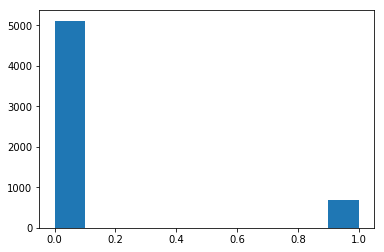

In [7]:
# Check class distribution
plt.hist(label)